<a href="https://colab.research.google.com/github/NerminWEST/Kaggle_Dataset_Fish_Model1.0/blob/main/YOLOv8nUnderwaterTunaDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("✓ Running on Google Colab")
else:
    print("✓ Running on Local Jupyter")

# %%
# Install required packages
!pip install ultralytics opencv-python-headless albumentations pyyaml -q

# %%
# Import libraries
import torch
import cv2
import numpy as np
import yaml
import shutil
from pathlib import Path
from IPython.display import Image, display, clear_output
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import os

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


✓ Running on Google Colab
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.5 MB/s eta 0:00:00
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.83 GB


In [2]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✓ Google Drive mounted!")

    # Set your dataset path in Google Drive
    # Update this to match your Google Drive path
    DRIVE_DATASET_PATH = '/content/drive/MyDrive/TunaDataset'

    # Copy dataset to local Colab storage for faster training
    print("\n📂 Copying dataset to local storage (faster training)...")
    LOCAL_DATASET_PATH = '/content/TunaDataset'

    if Path(DRIVE_DATASET_PATH).exists():
        if Path(LOCAL_DATASET_PATH).exists():
            shutil.rmtree(LOCAL_DATASET_PATH)
        shutil.copytree(DRIVE_DATASET_PATH, LOCAL_DATASET_PATH)
        print(f"✓ Dataset copied to: {LOCAL_DATASET_PATH}")
    else:
        print(f"⚠️  Dataset not found at: {DRIVE_DATASET_PATH}")
        print("Please update DRIVE_DATASET_PATH variable above!")
else:
    # For local Jupyter - update this to your dataset path
    LOCAL_DATASET_PATH = './TunaDataset'  # or 'C:/path/to/TunaDataset' on Windows
    print(f"📂 Using local dataset: {LOCAL_DATASET_PATH}")


Mounted at /content/drive
✓ Google Drive mounted!

📂 Copying dataset to local storage (faster training)...
✓ Dataset copied to: /content/TunaDataset


In [11]:
# %% [markdown]
#  📋 Step 4: Create Dataset Configuration
# Remove old YAML file if it exists (to avoid using cached incorrect paths)
old_yaml = Path(LOCAL_DATASET_PATH) / 'dataset.yaml'
if old_yaml.exists():
    print(f"🗑️  Removing old YAML file: {old_yaml}")
    old_yaml.unlink()
    print("✓ Old YAML removed")
else:
    print("ℹ️  No old YAML file found")

# Also check for other common YAML names
other_yamls = ['data.yaml', 'config.yaml', 'dataset.yml']
for yaml_name in other_yamls:
    yaml_path = Path(LOCAL_DATASET_PATH) / yaml_name
    if yaml_path.exists():
        print(f"🗑️  Found and removing: {yaml_path}")
        yaml_path.unlink()

print("✓ Ready to create fresh YAML")

# %%
def create_dataset_yaml(data_path, num_classes=1, class_names=['tuna']):
    """
    Create YOLO format dataset configuration for your folder structure

    Your structure:
    TunaDataset/
    ├── test/images + labels
    ├── train/images + labels
    └── valid/images + labels

    YOLO expects paths RELATIVE to the 'path' directory OR absolute paths
    """

    data_path = Path(data_path).absolute()

    # Use absolute paths to avoid confusion
    dataset_config = {
        'path': str(data_path),
        'train': str(data_path / 'train' / 'images'),  # Absolute path
        'val': str(data_path / 'valid' / 'images'),    # Absolute path
        'test': str(data_path / 'test' / 'images'),    # Absolute path
        'names': {i: name for i, name in enumerate(class_names)},
        'nc': num_classes
    }

    yaml_path = data_path / 'dataset.yaml'
    with open(yaml_path, 'w') as f:
        yaml.dump(dataset_config, f, default_flow_style=False)

    print(f"✓ Dataset config created: {yaml_path}")
    print("\nConfiguration:")
    print(f"  Path: {dataset_config['path']}")
    print(f"  Train: {dataset_config['train']}")
    print(f"  Val: {dataset_config['val']}")
    print(f"  Test: {dataset_config['test']}")
    print(f"  Classes: {num_classes}")
    print(f"  Names: {class_names}")

    # Verify paths exist
    print("\n🔍 Verifying paths:")
    for key in ['train', 'val', 'test']:
        path = Path(dataset_config[key])
        exists = path.exists()
        count = len(list(path.glob('*.jpg'))) + len(list(path.glob('*.png'))) if exists else 0
        status = '✓' if exists else '❌'
        print(f"  {key}: {status} ({count} images)")

    return str(yaml_path)

# %%
# Create dataset YAML with absolute paths
print("📝 Creating dataset configuration...")
data_yaml = create_dataset_yaml(
    LOCAL_DATASET_PATH,
    num_classes=1,
    class_names=['tuna']  # Update if you have multiple classes
)

# %%
# IMPORTANT: Verify the YAML file was created correctly
print("\n" + "="*70)
print("VERIFYING YAML FILE")
print("="*70)

yaml_path = Path(data_yaml)
if yaml_path.exists():
    print(f"✓ YAML file exists: {yaml_path}")

    # Read and display the YAML contents
    with open(yaml_path, 'r') as f:
        yaml_content = f.read()

    print("\n📄 YAML Contents:")
    print("-" * 70)
    print(yaml_content)
    print("-" * 70)

    # Parse and verify
    import yaml as yaml_lib
    with open(yaml_path, 'r') as f:
        config = yaml_lib.safe_load(f)

    print("\n🔍 Verifying paths in YAML:")
    all_paths_valid = True
    for key in ['train', 'val', 'test']:
        if key in config:
            path = Path(config[key])
            exists = path.exists()
            if exists:
                img_count = len(list(path.glob('*.jpg'))) + len(list(path.glob('*.png')))
                lbl_path = path.parent / 'labels'
                lbl_count = len(list(lbl_path.glob('*.txt'))) if lbl_path.exists() else 0
                print(f"  {key}: ✓ {path}")
                print(f"        Images: {img_count}, Labels: {lbl_count}")
            else:
                print(f"  {key}: ❌ {path} NOT FOUND!")
                all_paths_valid = False
        else:
            print(f"  {key}: ⚠️  Not specified in YAML")

    if all_paths_valid:
        print("\n✅ All paths are valid! Ready to train.")
    else:
        print("\n❌ Some paths are invalid! Fix the dataset structure before training.")
else:
    print(f"❌ YAML file not found: {yaml_path}")

print("="*70)

🗑️  Removing old YAML file: /content/TunaDataset/dataset.yaml
✓ Old YAML removed
🗑️  Found and removing: /content/TunaDataset/data.yaml
✓ Ready to create fresh YAML
📝 Creating dataset configuration...
✓ Dataset config created: /content/TunaDataset/dataset.yaml

Configuration:
  Path: /content/TunaDataset
  Train: /content/TunaDataset/train/images
  Val: /content/TunaDataset/valid/images
  Test: /content/TunaDataset/test/images
  Classes: 1
  Names: ['tuna']

🔍 Verifying paths:
  train: ✓ (1313 images)
  val: ✓ (79 images)
  test: ✓ (78 images)

VERIFYING YAML FILE
✓ YAML file exists: /content/TunaDataset/dataset.yaml

📄 YAML Contents:
----------------------------------------------------------------------
names:
  0: tuna
nc: 1
path: /content/TunaDataset
test: /content/TunaDataset/test/images
train: /content/TunaDataset/train/images
val: /content/TunaDataset/valid/images

----------------------------------------------------------------------

🔍 Verifying paths in YAML:
  train: ✓ /conte

🔍 Checking dataset structure...

Dataset root: /content/TunaDataset
Exists: True

📁 Contents of TunaDataset:
  - test/ ✓
    - labels/ ✓
    - images/ ✓
      (78 images)
  - dataset.yaml/ 
  - train/ ✓
    - labels/ ✓
    - images/ ✓
      (1313 images)
    - labels.cache/ 
  - valid/ ✓
    - labels/ ✓
    - images/ ✓
      (79 images)
    - labels.cache/ 
📸 Sample Training Images:
Looking in: /content/TunaDataset/train/images/
Looking for images in: /content/TunaDataset/train/images
Looking for labels in: /content/TunaDataset/train/labels
✓ Found 1313 images


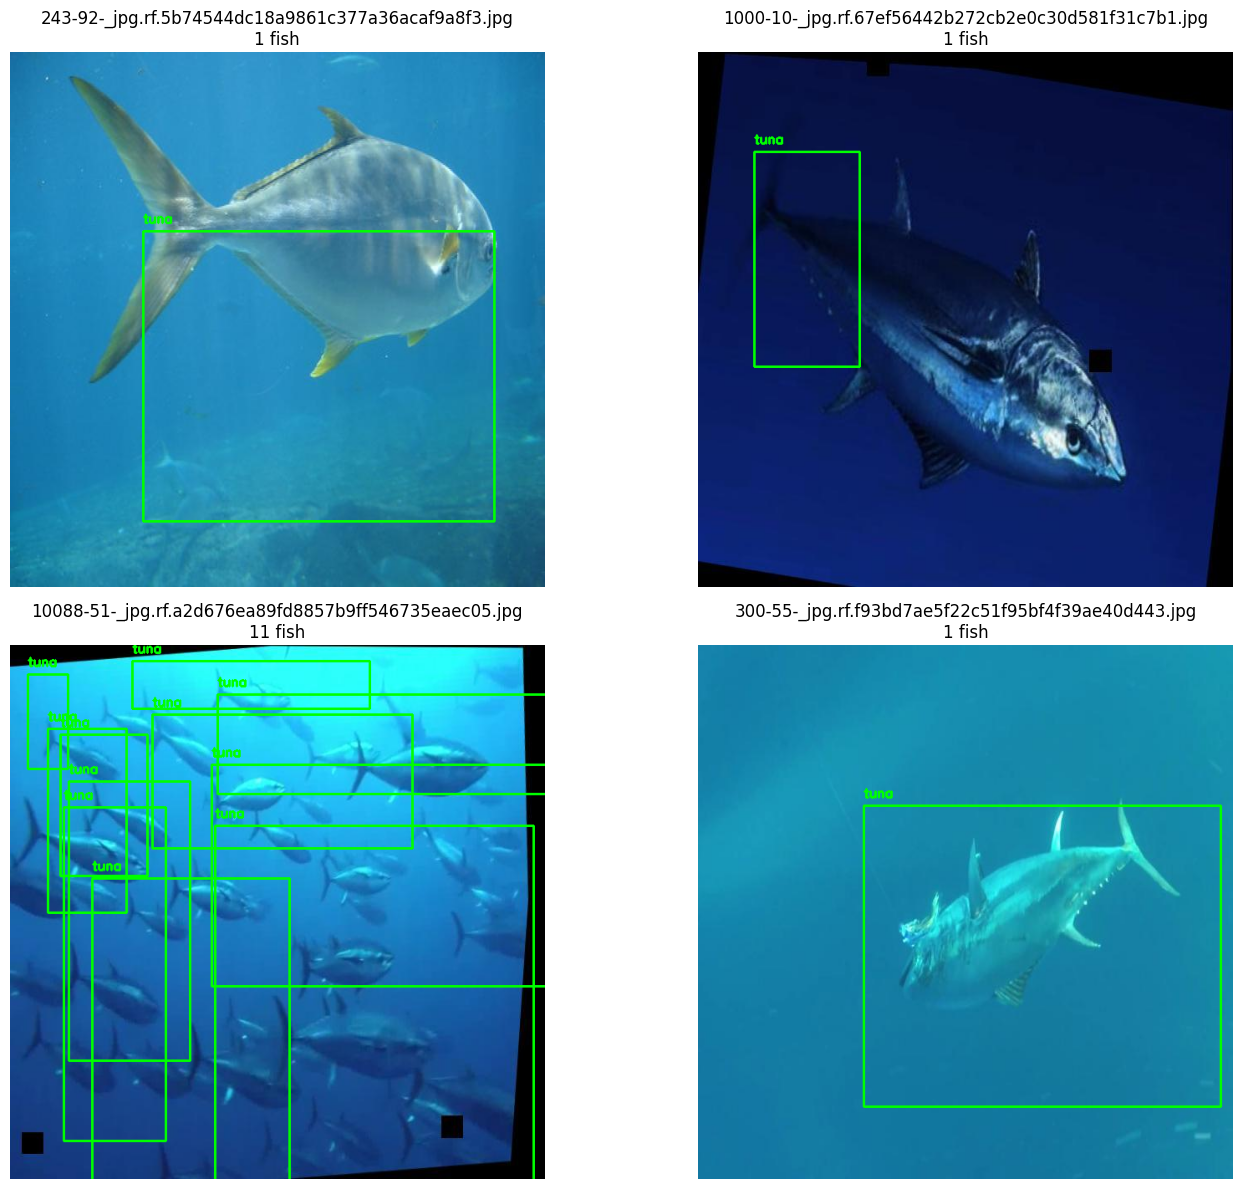

In [16]:
# ## 🎨 Step 5: Visualize Sample Images

# %%
# Debug: Check what folders actually exist
print("🔍 Checking dataset structure...")
data_path = Path(LOCAL_DATASET_PATH)
print(f"\nDataset root: {data_path}")
print(f"Exists: {data_path.exists()}")

if data_path.exists():
    print("\n📁 Contents of TunaDataset:")
    for item in data_path.iterdir():
        print(f"  - {item.name}/ {'✓' if item.is_dir() else ''}")
        if item.is_dir() and item.name in ['train', 'valid', 'test']:
            for subitem in item.iterdir():
                print(f"    - {subitem.name}/ {'✓' if subitem.is_dir() else ''}")
                if subitem.is_dir() and subitem.name == 'images':
                    num_images = len(list(subitem.glob('*.jpg'))) + len(list(subitem.glob('*.png')))
                    print(f"      ({num_images} images)")
else:
    print(f"❌ Dataset path does not exist!")

# %%
def visualize_samples(data_path, split='train', num_samples=4):
    """
    Display sample images with annotations

    Updated for your folder structure:
    TunaDataset/train/images and TunaDataset/train/labels
    """

    data_path = Path(data_path)
    split_path = data_path / split
    img_path = split_path / 'images'
    label_path = split_path / 'labels'

    print(f"Looking for images in: {img_path}")
    print(f"Looking for labels in: {label_path}")

    if not img_path.exists():
        print(f"❌ Image path not found: {img_path}")
        print(f"\n🔍 Let me check what exists:")
        if data_path.exists():
            print(f"Root exists: {data_path}")
            for item in data_path.iterdir():
                print(f"  Found: {item.name}")
        return

    # Get random images
    images = list(img_path.glob('*.jpg')) + list(img_path.glob('*.png'))
    print(f"✓ Found {len(images)} images")

    if len(images) == 0:
        print("❌ No images found!")
        return

    samples = np.random.choice(images, min(num_samples, len(images)), replace=False)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for idx, img_file in enumerate(samples):
        if idx >= 4:
            break

        # Read image
        img = cv2.imread(str(img_file))
        if img is None:
            print(f"⚠️  Failed to read: {img_file}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # Read corresponding label
        label_file = label_path / (img_file.stem + '.txt')

        num_fish = 0
        if label_file.exists():
            with open(label_file, 'r') as f:
                lines = f.readlines()

            num_fish = len(lines)

            # Draw bounding boxes
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue

                try:
                    cls, x_center, y_center, width, height = map(float, parts[:5])

                    # Convert YOLO format to pixel coordinates
                    x1 = int((x_center - width/2) * w)
                    y1 = int((y_center - height/2) * h)
                    x2 = int((x_center + width/2) * w)
                    y2 = int((y_center + height/2) * h)

                    # Draw rectangle
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(img, 'tuna', (x1, y1-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                except Exception as e:
                    print(f"⚠️  Error parsing label: {e}")
                    continue

        axes[idx].imshow(img)
        axes[idx].set_title(f"{img_file.name}\n{num_fish} fish")
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# %%
# Visualize training samples
print("📸 Sample Training Images:")
print(f"Looking in: {LOCAL_DATASET_PATH}/train/images/")
visualize_samples(LOCAL_DATASET_PATH, split='train', num_samples=4)


In [13]:
from ultralytics import YOLO

# Training configuration
EPOCHS = 100  # Number of epochs (adjust as needed)
BATCH_SIZE = 16  # Adjust based on GPU memory (8, 16, 32)
IMAGE_SIZE = 640  # Input image size
DEVICE = '0' if torch.cuda.is_available() else 'cpu'
PROJECT = 'marina_plus'
NAME = 'yolov8n_tuna'

print("="*70)
print("TRAINING CONFIGURATION")
print("="*70)
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Image Size: {IMAGE_SIZE}")
print(f"Device: {DEVICE}")
print(f"Project: {PROJECT}")
print(f"Name: {NAME}")
print("="*70)

# %%
# Initialize model with pretrained weights
model = YOLO('yolov8n-seg.pt')  # Segmentation model (includes masks)
# Use 'yolov8n.pt' for detection only (no masks, faster)

print("✓ Model loaded: YOLOv8n-seg (Segmentation)")
print("  This model will detect fish AND generate segmentation masks")

# %%
# Start training
print("\n🚀 Starting training...")
print("This may take 1-3 hours depending on your dataset size and GPU")

results = model.train(
    data=data_yaml,
    epochs=EPOCHS,
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    device=DEVICE,
    project=PROJECT,
    name=NAME,

    # Optimizer settings
    optimizer='Adam',
    lr0=0.001,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3,

    # Augmentation
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=10.0,
    translate=0.1,
    scale=0.5,
    flipud=0.0,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.1,

    # Training settings
    patience=50,
    save=True,
    cache=False,
    workers=8,
    exist_ok=True,
    pretrained=True,
    verbose=True,
    plots=True,

    # Loss weights
    box=7.5,
    cls=0.5,
    dfl=1.5,

    # Validation
    val=True,
)

print("\n✓ Training completed!")


TRAINING CONFIGURATION
Epochs: 100
Batch Size: 16
Image Size: 640
Device: 0
Project: marina_plus
Name: yolov8n_tuna
✓ Model loaded: YOLOv8n-seg (Segmentation)
  This model will detect fish AND generate segmentation masks

🚀 Starting training...
This may take 1-3 hours depending on your dataset size and GPU
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/TunaDataset/dataset.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=F

In [17]:
# Define project paths (in case training was done in a different session)
PROJECT = 'marina_plus'
NAME = 'yolov8n_tuna'
results_path = Path(PROJECT) / NAME

print("="*70)
print("LOADING TRAINED MODEL")
print("="*70)
print(f"Project: {PROJECT}")
print(f"Name: {NAME}")
print(f"Results path: {results_path}")
print(f"Exists: {results_path.exists()}")

# %%
# Load best model
best_model_path = results_path / 'weights' / 'best.pt'

print(f"\n🎯 Best model path: {best_model_path}")
print(f"Exists: {best_model_path.exists()}")

if best_model_path.exists():
    model = YOLO(str(best_model_path))
    print(f"✓ Model loaded from: {best_model_path}")
else:
    print(f"❌ Model not found at: {best_model_path}")
    print("\nℹ️  Training may not have completed yet, or files are in a different location.")
    print(f"Looking for models in: {results_path}")
    if results_path.exists():
        print("\n📁 Contents of results folder:")
        for item in results_path.iterdir():
            print(f"  - {item.name}")
        weights_path = results_path / 'weights'
        if weights_path.exists():
            print("\n📁 Available weights:")
            for weight in weights_path.iterdir():
                print(f"  - {weight.name}")
    else:
        print(f"❌ Results folder not found: {results_path}")
        print("\n💡 If training just started, wait for it to complete first!")

# %%
# Run validation
print("\n📊 Running validation...")

metrics = model.val(
    data=data_yaml,
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    device=DEVICE,
    plots=True,
    save_json=True
)

# %%
# Print detailed metrics
print("\n" + "="*70)
print("VALIDATION METRICS")
print("="*70)

print("\n📦 Detection Metrics:")
print(f"  mAP50: {metrics.box.map50:.4f}")
print(f"  mAP50-95: {metrics.box.map:.4f}")
print(f"  Precision: {metrics.box.mp:.4f}")
print(f"  Recall: {metrics.box.mr:.4f}")

if hasattr(metrics, 'seg') and metrics.seg is not None:
    print("\n🎯 Segmentation Metrics:")
    print(f"  Seg mAP50: {metrics.seg.map50:.4f}")
    print(f"  Seg mAP50-95: {metrics.seg.map:.4f}")
    print(f"  Seg Precision: {metrics.seg.mp:.4f}")
    print(f"  Seg Recall: {metrics.seg.mr:.4f}")

if hasattr(metrics, 'speed'):
    print("\n⚡ Speed Metrics:")
    print(f"  Preprocess: {metrics.speed['preprocess']:.2f}ms")
    print(f"  Inference: {metrics.speed['inference']:.2f}ms")
    print(f"  Postprocess: {metrics.speed['postprocess']:.2f}ms")
    total_time = sum(metrics.speed.values())
    print(f"  Total: {total_time:.2f}ms ({1000/total_time:.1f} FPS)")

print("\n" + "="*70)


LOADING TRAINED MODEL
Project: marina_plus
Name: yolov8n_tuna
Results path: marina_plus/yolov8n_tuna
Exists: True

🎯 Best model path: marina_plus/yolov8n_tuna/weights/best.pt
Exists: True
✓ Model loaded from: marina_plus/yolov8n_tuna/weights/best.pt

📊 Running validation...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 11.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 802.0±278.9 MB/s, size: 25.9 KB)
val: Scanning /content/TunaDataset/valid/labels.cache... 79 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 79/79 130.4Kit/s 0.0s
requirements: Ultralytics requirement ['faster-coco-eval>=1.6.7'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 2 packages in 237ms
Prepared 1 package in 39ms
Installed 1 package in 2ms
 + faster-coco-eval==1.7.0

requirements: AutoUpdate success ✅ 1.4s
WARNING ⚠️ requirements: Restart runtime or

🧪 Testing on Validation Samples:


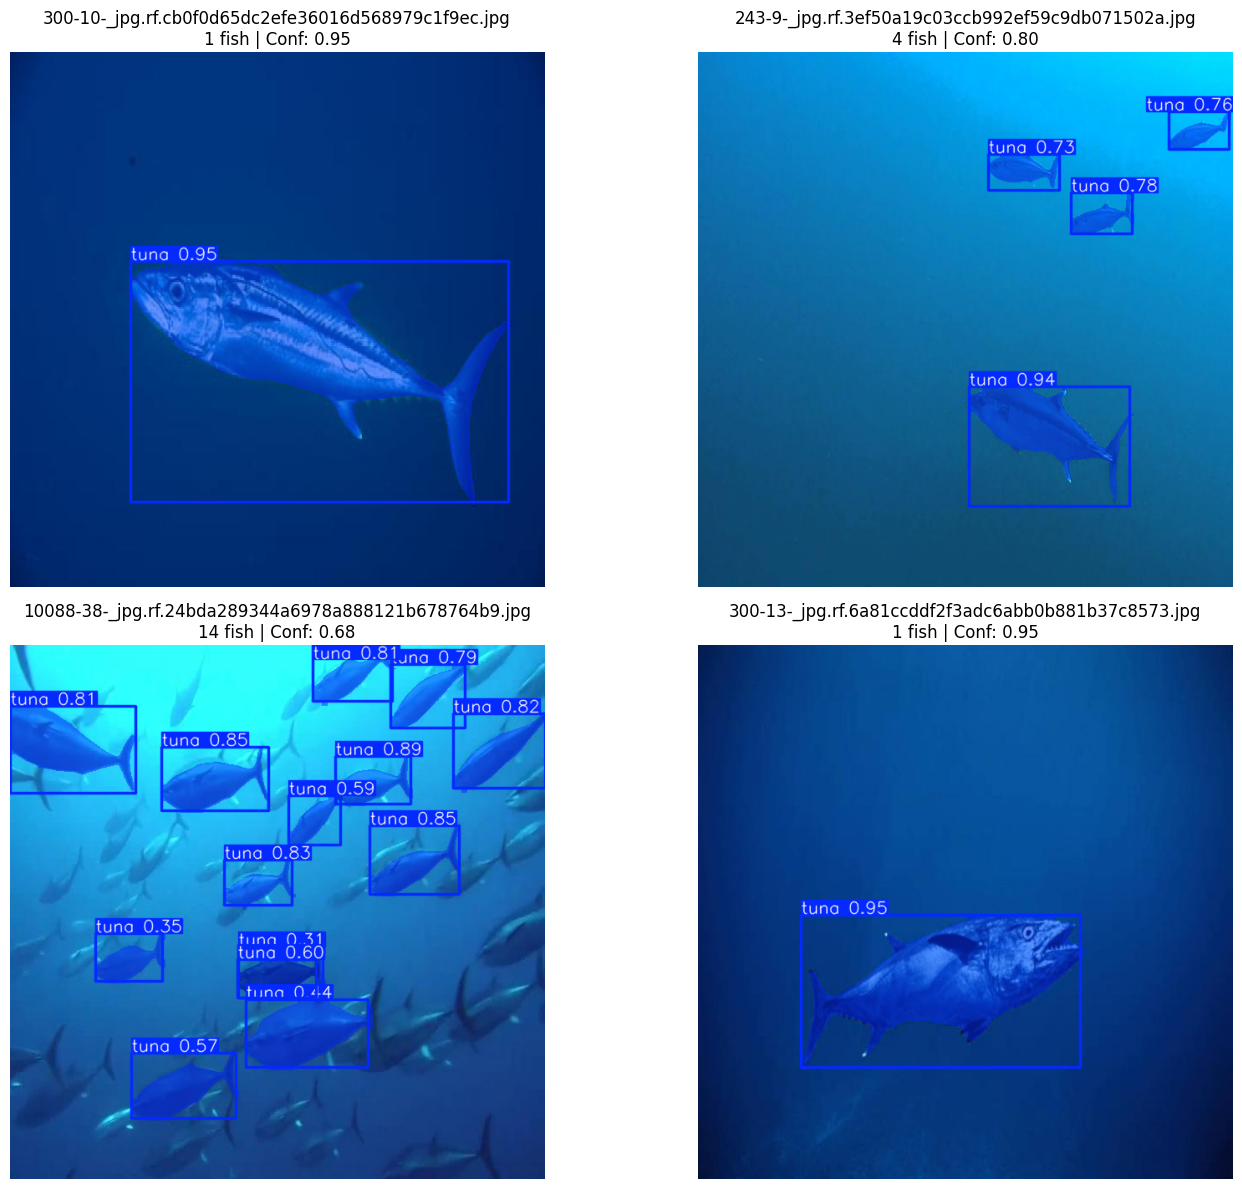

In [18]:
def test_on_samples(model, data_path, split='valid', num_samples=4, conf_threshold=0.25):
    """
    Test model on sample images and display results
    Updated for your folder structure (valid instead of val)
    """

    data_path = Path(data_path)
    split_path = data_path / split
    img_path = split_path / 'images'

    if not img_path.exists():
        print(f"Image path not found: {img_path}")
        return

    # Get random images
    images = list(img_path.glob('*.jpg')) + list(img_path.glob('*.png'))
    if len(images) == 0:
        print("No images found!")
        return

    samples = np.random.choice(images, min(num_samples, len(images)), replace=False)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for idx, img_file in enumerate(samples):
        if idx >= 4:
            break

        # Run inference
        results = model.predict(
            source=str(img_file),
            conf=conf_threshold,
            save=False,
            verbose=False
        )

        # Get annotated image
        annotated_img = results[0].plot()
        annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

        # Count detections
        num_detections = len(results[0].boxes)
        confidences = results[0].boxes.conf.cpu().numpy() if num_detections > 0 else []
        avg_conf = confidences.mean() if len(confidences) > 0 else 0

        axes[idx].imshow(annotated_img)
        axes[idx].set_title(f"{img_file.name}\n{num_detections} fish | Conf: {avg_conf:.2f}")
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# %%
# Test on validation samples
print("🧪 Testing on Validation Samples:")
test_on_samples(model, LOCAL_DATASET_PATH, split='valid', num_samples=4, conf_threshold=0.25)

In [19]:
if IN_COLAB:
    # Save best model to Google Drive
    drive_save_path = '/content/drive/MyDrive/marina_plus_models'
    Path(drive_save_path).mkdir(parents=True, exist_ok=True)

    # Copy best model
    shutil.copy(
        str(best_model_path),
        f"{drive_save_path}/yolov8n_tuna_best.pt"
    )

    # Copy entire results folder
    drive_results_path = f"{drive_save_path}/training_results"
    if Path(drive_results_path).exists():
        shutil.rmtree(drive_results_path)
    shutil.copytree(str(results_path), drive_results_path)

    print(f"✓ Model saved to Google Drive:")
    print(f"  Model: {drive_save_path}/yolov8n_tuna_best.pt")
    print(f"  Results: {drive_results_path}")
else:
    print(f"✓ Model saved locally:")
    print(f"  Path: {best_model_path}")


✓ Model saved to Google Drive:
  Model: /content/drive/MyDrive/marina_plus_models/yolov8n_tuna_best.pt
  Results: /content/drive/MyDrive/marina_plus_models/training_results


In [20]:
# Export to different formats for deployment
export_formats = ['onnx', 'torchscript']  # Add 'tflite' for Raspberry Pi

print("📦 Exporting model...")

for fmt in export_formats:
    try:
        print(f"\nExporting to {fmt.upper()}...")
        export_path = model.export(
            format=fmt,
            imgsz=IMAGE_SIZE,
            optimize=True,
            simplify=True
        )
        print(f"  ✓ Exported: {export_path}")
    except Exception as e:
        print(f"  ❌ Export failed: {e}")


📦 Exporting model...

Exporting to ONNX...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'marina_plus/yolov8n_tuna/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 37, 8400), (1, 32, 160, 160)) (6.5 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 182ms
Prepared 6 packages in 8.98s
Installed 6 packages in 1.44s
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.19.1
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.78

requirements: AutoUpdate success ✅ 10.9s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx